# Options Pricing

_The essence of investment management is the management of risks, not the management of returns_ - Benjamin Graham

__Concepts__

- Options
- Binomial Tree Pricing
- Black-Scholes-Merton
- VIX
- Monte Carlo Simulation

__References__

- F. Black and M. Scholes, “The Pricing of Options and Corporate Liabilities,” Journal of Political Economy, 81 (May/June 1973): 637–59
- R. C. Merton, “Theory of Rational Option Pricing,” Bell Journal of Economics and Management Science 4 (Spring 1973): 141–183. 
- Cox, Ross, Rubinstein, 1979
- FRM Part I Exam Book Financial Markets and Products Ch. 14-15
- FRM Part I Exam Book Quantitative Analysis Ch. 13
- FRM Part I Exam Book Valuation and Risk Models Ch. 14-16 
- FRM Part II Exam Book Market Risk Measurement and Management Ch. 15 



In [1]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from finds.utils import row_formatted
from finds.readers import Alfred
from secret import credentials
VERBOSE = 0
#%matplotlib qt

## Options

A __European__ call (or put) option gives the buyer the right to buy (or sell) an asset at a certain price on a specific date. An __American__ call (or put) option gives the buyer the right to buy (or sell) an asset at a certain price at any time before or on the specified date. The date specified in the option is known as the __expiration__ date (also called the __maturity__ date).  The price at which an asset can be bought or sold using an option is referred to as the __strike__ price (also called the __exercise__ price). 

Options can be in-the-money, at-the-money, or out-of-the-money. This is referred to as their moneyness. Under the simplest definition of these terms, it is imagined what would happen if the option could be exercised today. An option that would give a positive payoff if exercised today is referred to as in-the-money. If it would give a negative payoff, the option is referred to as out-of-the money. An option that is at-the-money would give a payoff of zero.

The price of stock option depends on the:
- price of the underlying stock, S
- strike price, K
- risk-free rate, r
- volatility of the stock price, $\sigma$
- time to maturity, T, 
- dividends to be paid during the life of the option, q

Put-call parity describes the relationship between the price of a European call option and that of a European put option with the same strike price and time to maturity: $S - C = PV(K) - P$



### Option Strategies

Trading strategies involve entering positions simultaneously in different options and, optionally (no put intended), the underlying asset.

- Buying a put option when the underlying asset is held is referred to as a __protective__ put strategy. A put option combined with the asset gives a position equivalent to a call option combined with an amount of cash equal to PV(K)

- An asset plus a short call is known as a __covered call__. The call is usually out-of-the-money, allowing the asset owner to obtain a cash inflow equal to the call option premium in exchange for giving up some

- A __bull spread__  is a position appropriate for an investor expecting an increase in the price of an asset. To create the spread, the trader buys a European call option with strike price K1 and sells a European call option with higher strike price K2. 

- A __bear spread__ is a position where the trader buys a Euro-pean put option with strike price K2 and sells a European put option with lower strike price K1.

- A __box spread__ is a portfolio created from a bull spread (using call options) and a bear spread (using put options). The strike prices and times to maturity used for the bull spread are the same as those used for the bear spread. 

- A __butterfly spread__ involves positions in three options. It can be created from either call or put options. If calls are used, a trader will take positions in one long European call with strike price K1,one long European call with higher strike price K3, and two short European calls with strike price K2 = (K1 + K3)/2.

- To create a __calendar spread__, a trader buys a call option maturing at time T* and sells a call maturing at a nearer time T, both at the same strike price of K

- A __straddle__ is created from a long call and a long put with the same strike price and time to maturity. 

- A __strangle__ position reduces the cost of a straddle by making the strike price of the call greater than the strike price of the put.

In [2]:
# define call and put payoffs at maturity
def call_payoff(K):
    return lambda s: s - K if s > K else 0

def put_payoff(K):
    return lambda s: K - s if s < K else 0

In [3]:
# helpers to plot final payoff of option strategy
def plot_payoff(payoff, S=np.linspace(70, 130, 60), ax=None, label=''):
    """helper to plot final payoff over range of stock price S"""
    ax = ax or plt.gca()
    df = DataFrame([payoff(s) for s in S], index=S)
    zeros = (df == 0).all(axis=0)
    df = df.drop(columns=df.columns[zeros])
    df = df + np.sign(df.sum(axis=0))*0.4    # jigger so can display separate
    y = df.sum(axis=1).rename(label)
    y.plot(ax=ax, lw=3)
    df.plot(marker='.', ls='', ms=4, ax=ax)
    ax.legend([label] + list(df.columns))

def _ls(n):
    """helper to label as long or short position"""
    return 'long' if n >=0 else 'short'

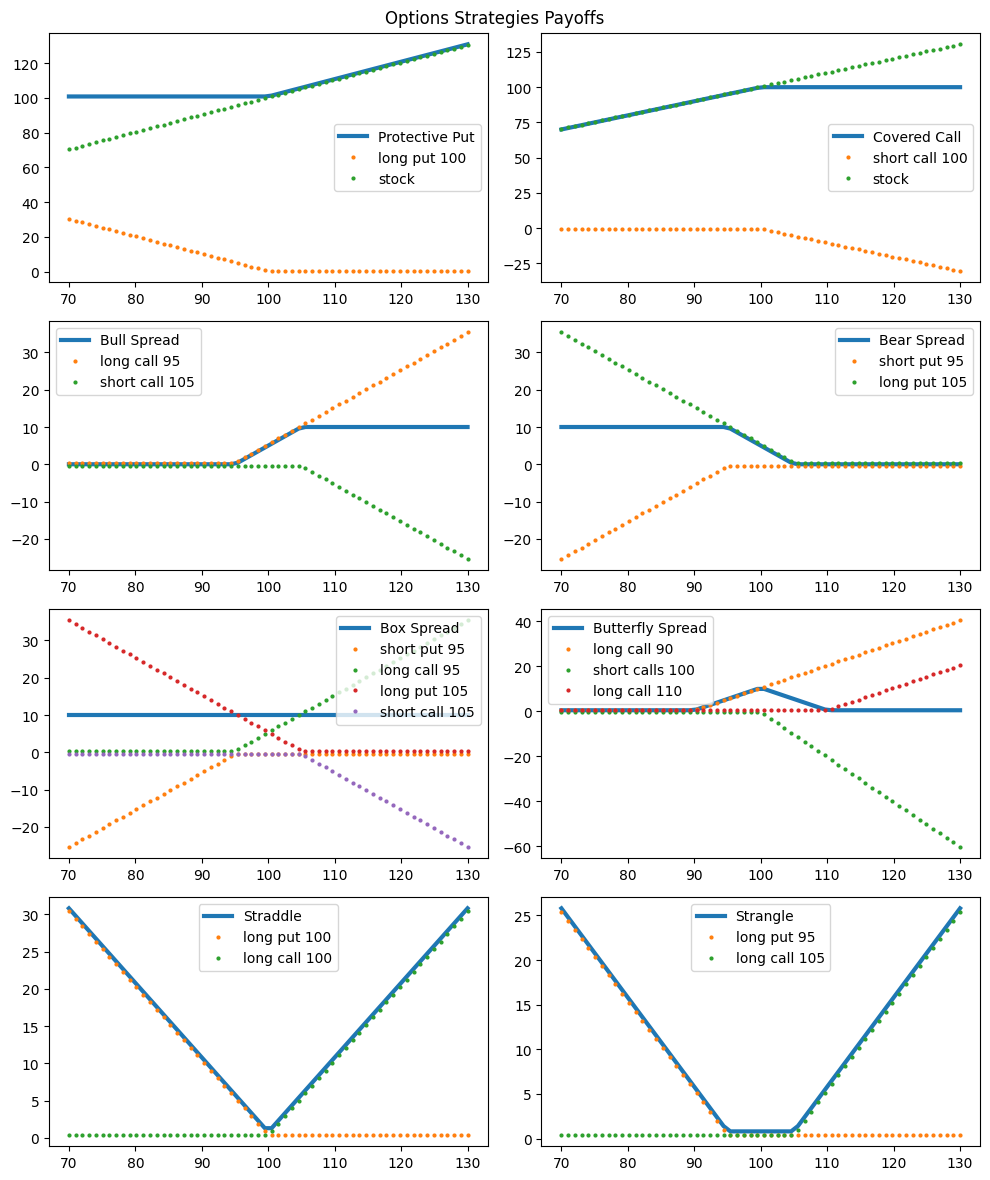

In [4]:
# Define and plot the options strategies
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,12))
ax = ax.flatten()

def options_strategy(K, calls=0, puts=0, stocks=0):
    return lambda s: {f"{_ls(calls)} call {K}": calls*call_payoff(K)(s),
                      f"{_ls(puts)} put {K}": puts*put_payoff(K)(s),
                      "stock": stocks*s}

plot_payoff(options_strategy(K=100, puts=1, stocks=1), ax=ax[0], label='Protective Put')

plot_payoff(options_strategy(K=100, calls=-1, stocks=1), ax=ax[1], label='Covered Call')

def bull_spread(K1, K2):
    assert K2 > K1, "K2 must be greater than K1"
    return lambda s: {f"long call {K1}": call_payoff(K1)(s),
                      f"short call {K2}": -call_payoff(K2)(s)}

plot_payoff(bull_spread(K1=95, K2=105), ax=ax[2], label='Bull Spread')

def bear_spread(K1, K2):
    assert K2 > K1, "K2 must be greater than K1"
    return lambda s: {f"short put {K1}": -put_payoff(K1)(s),
                      f"long put {K2}": put_payoff(K2)(s)}

plot_payoff(bear_spread(K1=95, K2=105), ax=ax[3], label='Bear Spread')

def box_spread(K1, K2):
    assert K2 > K1, "K2 must be greater than K1"
    return lambda s: {f"short put {K1}": -put_payoff(K1)(s),
                      f"long call {K1}": call_payoff(K1)(s),
                      f"long put {K2}": put_payoff(K2)(s),
                      f"short call {K2}": -call_payoff(K2)(s)}

plot_payoff(box_spread(K1=95, K2=105), ax=ax[4], label='Box Spread')

def butterfly_spread(K1, K3):
    assert K3 > K1, "K3 must be greater than K1"
    K2 = (K1 + K3) / 2
    return lambda s: {f"long call {K1}": call_payoff(K1)(s),
                      f"short calls {K2:g}": -2*call_payoff(K2)(s),
                      f"long call {K3}": call_payoff(K3)(s)}

plot_payoff(butterfly_spread(K1=90, K3=110), ax=ax[5], label='Butterfly Spread')

def straddle(K):
    return lambda s: {f"long put {K}": put_payoff(K)(s),
                      f"long call {K}": call_payoff(K)(s)}                      
plot_payoff(straddle(K=100), ax=ax[6], label='Straddle')

def strangle(K1, K2):
    assert K2 > K1, "K2 must be greater than K1"
    return lambda s: {f"long put {K1}": put_payoff(K1)(s),
                      f"long call {K2}": call_payoff(K2)(s)}
plot_payoff(strangle(K1=95, K2=105), ax=ax[7], label='Strangle')

plt.suptitle('Options Strategies Payoffs')
plt.tight_layout()

### Exotic Options

Standard European and American options are termed plain vanilla options. Options with non-standard properties are termed exotic options (or simply exotics).

- The exercise of a __Bermudan__ option is restricted to certain dates.

- A __forward start__ option is an option that will begin at a future time. It is usually stated that the option will be at-the-money at the time it starts. 

- A __gap__ option is a European call or put option where the price triggering a payoff is different from the price used in calculating the payoff.

- A __cliquet__ option is a series of forward start options with certain rules for determining the strike prices.

- __Binary__ call (put) options may a fixed amount of cash or an asset when its price is above (below) the strike price, or nothing otherwise.  Cash-or-nothing optinos are sometimes referred to as __digital__ options.

- __Asian__ options provide a payoff dependent on an arithmetic aver-age of the underlying asset price during the life of the option. 

- The payoff from a __lookback__ option depends on the maximum or minimum asset price reached during the life of the option. A floating lookback call (put) gives a payoff equal difference between the final asset price and minimum (maximum) price. The payoff of a fixed lookback call (put) is based on the difference betwen the maximum (minimum) price and the strike price.

- __Barrier__ options come into existence or ceases to exist depending on whether the asset price reaches a particular barrier.  There are down-and-out, down-and-in, up-and-out and up-and-in variants.

- A __compound__ option is an option on another option. Thus, there are two strike prices and two maturity dates.

- In an __asset-exchange__ option, the holder has the right to exchange one asset for another. 

- A __volatility swap__ is a forward contract on the realized volatility of an asset during a certain period. A trader agrees to exchange a pre-specified volatility for the realized volatility at the end of the period.


## Binomial Tree

This valuation technique was proposed by Cox, Ross, and Rubinstein (1979) and continues to widely used for pricing American-style options and many other derivatives.

### No-arbitrage

The no-arbitrage argument means that prices are calculated on the assumption that there are no arbitrage opportunities for market participants. The __law of one price__ states that if two portfolios provide the same cash flows at the same times in the future, they should sell for the same price. Otherwise, a trader can short the more expensive portfolio and buy the cheaper portfolio to lock in a riskless profit. Binomial trees apply no-arbitrage arguments to pricing derivatives. 

Suppose that the price of a non-dividend paying stock is currently $S$, and that during a time T it will either move up to $Su$ or down to $Sd$. We consider a derivative that provides a payoff of $f_u$ if the stock price increases, and a payoff of $f_d$ if the stock price decreases. We then form a portfolio consisting of: 
- A short position in one unit of the derivative; and
- A position of $\Delta$ in the stock which we set to equal

$\Delta = \dfrac{f_u - f_d}{S u - S d}$

The value of the portfolio at time T is
- $S u \Delta - f_u$ if the stock price increases, and 
- $S d \Delta - f_d$ if the stock price decreases. 

The value of the portfolio today is $S \Delta - f$, where f is the value of the derivative today. Suppose r is the risk-free rate for maturity T. For no arbitrage, we must have

$S \Delta - f = \dfrac{f_ud - f_du}{u - d}e^{-rT}$

Substituting for $\Delta$, gives: 

$$f = e^{-rT}[pf_u + (1 - p)f_d]$$

where: $p = \dfrac{e^{rT} - d}{u - d}$



### Risk Neutral Pricing
We will also use binomial trees to introduce what is known as risk-neutral valuation. This is a result that allows derivatives to be valued by assuming that market participants require an expected return equal to the risk-free rate on all investments.
We define a risk-neutral world as one where investors do not adjust their required expected returns for risk, so that the expected return on all assets is the risk-free rate. To put this another way, a risk-neutral world is one where all tradable assets have an expected return equal to the risk-free interest rate. The probabilities of different outcomes in a risk-neutral world are therefore based on this assumption, and a risk-neutral investor has no preference between assets with different risks. The risk-neutral valuation principle states that if we assume we are in a risk-neutral world, we get the correct price for a deriva-tive. As it turns out, the price is correct in the real world (where investors do care about risk) as well as in a risk-neutral world. 

First, we note that if we choose to interpret the variable p as the probability of an upward movement (with 1 - p being the probability of a downward movement), then expected stock price grows at the risk-free rate. It also means that p is the probability of an upward movement in a risk-neutral world.

We have therefore demonstrated the truth of the risk-neutral valuation result. If we assume a risk-neutral world, the probability of an upward movement is p, and the value of the derivative is its expected payoff discounted at the risk-free rate (i.e., it is the value that would apply if market participants were risk neutral).

It should be emphasized that the risk-neutral valuation is noth-ing more than an artificial way of valuing derivatives. We are not assuming that the world is actually risk-neutral. We are instead arguing that the price of a derivative is the same in the real world as it would be in the risk-neutral world


### Binomial Trees for Valuing Options

In practice, we model stock price changes using a multi-step tree, and define
- the length of a tree step as $\Delta t$
- the parameters u and d should be chosen to reflect the volatility of
  the stock price. If we denote the volatility per year by $\sigma$, then appropriate values for the parameters are 
  - $u = e^{\sigma \sqrt{\Delta t}}$
  - $u = e^{-\sigma \sqrt{\Delta t}}$

  where $\Delta t$ is measured in years.
- hence 
  $$f = e^{-r \Delta t} [p f_u + (1 - p) f_d]$$
  where $p = \dfrac{e^{r \Delta t} - d}{u - d}$

- the delta, or position taken in the stock to hedge a short posion
  in the derivative, is $\Delta = \dfrac{f_u - f_d}{Su - Sd}$


__Dividends__: Suppose a stock paying a continuous dividend yield at rate $q$. Then we adjust the formula for $p$, whie everything else about the tree, including the calculation of $u$ and $d$ and the roll back procedure, is the same as before
$$p = \dfrac{e^{(r - q)\Delta t} - d}{u - d}$$

__Currency Options__: A currency can be considered as an asset providing a yield at the foreign risk-free rate. Therefore, the analysis we presented for a stock paying a continuous dividend yield applies, with q equal to the foreign risk-free rate. 

__Futures__: Because it costs nothing to enter into a futures contract, the return on a futures contract in a risk-neutral world must be zero. This means we can treat a futures contract like a stock, paying a continuous dividend yield equal to the risk free rate. 


In [5]:
def binomial_tree(S, sigma, r, T, steps, payoff=None, q=0, american=False,
                  verbose=True):
    delta_t = T / steps    
    u = np.exp(sigma * np.sqrt(delta_t))
    d = np.exp(-sigma * np.sqrt(delta_t))
    p = (np.exp((r - q) * delta_t) - d) / (u - d)
    result = dict(value=None, u=u, d=d, p=p, delta_t=delta_t)
    if payoff is not None:
        label = "STEP {:<5d}".format    # to label output of each step

        # initialize price vectors at last step
        prices = DataFrame(0.0, index=np.arange(steps+1),
                           columns=['stock', 'option', 'delta'])
        for downs in range(steps+1):
            s = d**downs * u**(steps-downs) * S      # price after number of downs
            prices.loc[downs, 'stock'] = s
            prices.loc[downs, 'option'] = payoff(s)  # option value at expiry
        print(row_formatted(prices.T.rename_axis(columns=label(steps)),
                            default="{:.4f}"))
        
        # roll back one time step at a time
        for step in range(steps - 1, -1, -1):

            # update all scenarios in this time step
            for downs in range(step+1):

                # stock price after this number of downs
                s = d**downs * u**(step - downs) * S  
                prices.loc[downs, 'stock'] = s
                
                # value of option is max of roll back or exercise (if American)
                exercise = payoff(s) if american else 0  # if exercise American
                f_u = prices.loc[downs, 'option']        # option value after up
                f_d = prices.loc[downs + 1, 'option']    # option value after down
                f = np.exp(-r * delta_t) * (p * f_u + (1 - p) * f_d)
                prices.loc[downs, 'option'] = max(f, exercise)
                prices.loc[downs, 'delta'] = (f_u - f_d) / (S*u - S*d)

            # Display this time step
            prices = prices.iloc[:-1]
            print()
            print(row_formatted(prices.T.rename_axis(columns=label(step)),
                                default="{:.4f}"))
        result['value'] = prices.loc[0, 'option']
    return DataFrame(result, index=[steps]).rename_axis(columns='STEPS').round(4)

European call option in 2 steps


In [6]:
# Figure 14.3 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=29, sigma=0.25, r=0.03, T=1, steps=2,
              payoff=call_payoff(K=30))

STEP 2            0        1        2
stock       41.2995  29.0000  20.3635
option      11.2995   0.0000   0.0000
delta        0.0000   0.0000   0.0000

STEP 1            0        1
stock       34.6076  24.3010
option       5.5483   0.0000
delta        1.0963   0.0000

STEP 0            0
stock       29.0000
option       2.7243
delta        0.5383


STEPS,value,u,d,p,delta_t
2,2.7243,1.1934,0.838,0.4984,0.5


European put option in 2 steps


In [7]:
# Figure 14.4 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=29, sigma=0.25, r=0.03, T=1, steps=2,
              payoff=put_payoff(K=30))

STEP 2            0        1        2
stock       41.2995  29.0000  20.3635
option       0.0000   1.0000   9.6365
delta        0.0000   0.0000   0.0000

STEP 1            0        1
stock       34.6076  24.3010
option       0.4941   5.2523
delta       -0.0970  -0.8380

STEP 0            0
stock       29.0000
option       2.8377
delta       -0.4617


STEPS,value,u,d,p,delta_t
2,2.8377,1.1934,0.838,0.4984,0.5


American put option in 4 steps


In [8]:
# Figure 14.5 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=29, sigma=0.25, r=0.03, T=1, steps=2,
              payoff=put_payoff(K=30), american=True)

STEP 2            0        1        2
stock       41.2995  29.0000  20.3635
option       0.0000   1.0000   9.6365
delta        0.0000   0.0000   0.0000

STEP 1            0        1
stock       34.6076  24.3010
option       0.4941   5.6990
delta       -0.0970  -0.8380

STEP 0            0
stock       29.0000
option       3.0584
delta       -0.5050


STEPS,value,u,d,p,delta_t
2,3.0584,1.1934,0.838,0.4984,0.5


American put option in 4 steps


In [9]:
# Figure 14.6 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=29, sigma=0.25, r=0.03, T=1, steps=4,
              payoff=put_payoff(K=30), american=True)

STEP 4            0        1        2        3        4
stock       47.8129  37.2367  29.0000  22.5852  17.5894
option       0.0000   0.0000   1.0000   7.4148  12.4106
delta        0.0000   0.0000   0.0000   0.0000   0.0000

STEP 3            0        1        2        3
stock       42.1948  32.8613  25.5924  19.9314
option       0.0000   0.4974   4.4076  10.0686
delta        0.0000  -0.1376  -0.8825  -0.6873

STEP 2            0        1        2
stock       37.2367  29.0000  22.5852
option       0.2474   2.4387   7.4148
delta       -0.0684  -0.5379  -0.7788

STEP 1            0        1
stock       32.8613  25.5924
option       1.3356   4.8958
delta       -0.3015  -0.6846

STEP 0            0
stock       29.0000
option       3.0966
delta       -0.4898


STEPS,value,u,d,p,delta_t
4,3.0966,1.1331,0.8825,0.4988,0.25


European call on index with dividend yield


In [10]:
# Figure 14.7 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=2500, sigma=0.15, r=0.03, q=0.02, T=0.5, steps=3,
              payoff=call_payoff(K=2500))

STEP 3              0          1          2          3
stock       3004.1734  2657.8778  2351.5002  2080.4391
option       504.1734   157.8778     0.0000     0.0000
delta          0.0000     0.0000     0.0000     0.0000

STEP 2              0          1          2
stock       2825.7257  2500.0000  2211.8212
option       328.7911    78.2792     0.0000
delta          1.1303     0.5153     0.0000

STEP 1              0          1
stock       2657.8778  2351.5002
option       202.0979    38.8125
delta          0.8177     0.2555

STEP 0              0
stock       2500.0000
option       119.5793
delta          0.5330


STEPS,value,u,d,p,delta_t
3,119.5793,1.0632,0.9406,0.4983,0.1667


American call option on foreign currency


In [11]:
# Figure 14.8 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=0.78, sigma=0.12, r=0.02, q=0.06, T=1, steps=4,
              payoff=call_payoff(K=0.8))

STEP 4           0       1       2       3       4
stock       0.9916  0.8794  0.7800  0.6918  0.6136
option      0.1916  0.0794  0.0000  0.0000  0.0000
delta       0.0000  0.0000  0.0000  0.0000  0.0000

STEP 3           0       1       2       3
stock       0.9338  0.8282  0.7346  0.6515
option      0.1239  0.0318  0.0000  0.0000
delta       1.1972  0.8483  0.0000  0.0000

STEP 2           0       1       2
stock       0.8794  0.7800  0.6918
option      0.0685  0.0127  0.0000
delta       0.9837  0.3394  0.0000

STEP 1           0       1
stock       0.8282  0.7346
option      0.0350  0.0051
delta       0.5955  0.1358

STEP 0           0
stock       0.7800
option      0.0170
delta       0.3191


STEPS,value,u,d,p,delta_t
4,0.017,1.0618,0.9418,0.4021,0.25


American put option on futures contract


In [12]:
# Figure 14.9 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=38, sigma=0.2, r=0.04, q=0.04, T=9/12, steps=3,
              payoff=put_payoff(K=40), american=True)

STEP 3            0        1        2        3
stock       51.2946  41.9965  34.3838  28.1511
option       0.0000   0.0000   5.6162  11.8489
delta        0.0000   0.0000   0.0000   0.0000

STEP 2            0        1        2
stock       46.4133  38.0000  31.1118
option       0.0000   2.9190   8.8882
delta        0.0000  -0.7377  -0.8187

STEP 1            0        1
stock       41.9965  34.3838
option       1.5172   5.9925
delta       -0.3834  -0.7841

STEP 0            0
stock       38.0000
option       3.8282
delta       -0.5879


STEPS,value,u,d,p,delta_t
3,3.8282,1.1052,0.9048,0.475,0.25


## Black-Scholes-Merton

The famous Black-Scholes-Merton model was published in two papers in 1973 and has had a major influence on the way options are priced and hedged. In one of the papers, Black and Scholes used the capital asset pricing model (CAPM) to derive the relationship between the return from a stock and the return from an option on the stock. In the other paper, Merton used no-arbitrage arguments like those used in connection with binomial trees in the previous chapter. The two papers derived the same option pricing formula.

Merton used assumptions and arguments (many of which are similar to those for valuaing options using binomial trees), including lognormal stock price distribution, continuous security trading and no riskless opportunities, to show that the price evolution of derivatives satisfies the Black-Scholes-Merton partial differential equation.

$$\dfrac{\partial V}{\partial t} + \dfrac{1}{2}\sigma^2 S^2 \dfrac{\partial^2S}{\partial S^2} + rS \dfrac{\partial V}{\partial S} - rV = 0$$

To use Merton’s result to value a European option, we must apply boundary conditions. For a European call option with time to maturity T and strike price K, the boundary condition is that the value of the option is max(S - K, 0) at time T. For a European put, this boundary condition is max(K - S, 0). Other derivatives give rise to other boundary conditions. 

The solutions for the prices of a European call and put are the Black-Scholes-Merton formulas:

$$C = S e^{-qT} \Phi(d_1) - Ke^{-rT} \Phi(d_2)$$

$$p = Ke^{-rT} \Phi(-d_2) - S e^{-qT} \Phi(-d_1)$$

where: 
- $d_1 = \dfrac{\ln(S_0/K) + (r - q + \sigma^2/2)T}{\sigma\sqrt{T}}$
- $d_2 = \dfrac{\ln(S_0/K) + (r - q- \sigma^2/2)T}{\sigma\sqrt{T}} = d_1 - \sigma\sqrt{T}$
- $S$ is the current stock price, 
- K is the strike price, 
- T is the time to maturity in years, 
- r is the risk-free rate per year (continuously compounded),
- q is the dividend yield (or foreign risk-free rate for currency options)
- $\sigma$ is an estimated volatility per year over the next T years, 
- $\Phi$ is the cumulative normal distribution function

Suppose discreate dividends are expected bo be paid with ex-dates during the life of the option. The option can be valued by replacing stock price S with S - PV(D), the present value of those dividends.

American call options on a non-dividend paying stock should never be exercised early, hence the same formulaprovides prices for American call options on non-dividend paying stocks as well as for European call options. But it may be optimal to exercise early when there are discrete dividends, but only immediately before an ex-dividend date. 

American put options on stocks and all American options on stock indices, currencies, and futures should not be valued as European options. Binomial trees can be used in these case.


Black-Scholes-Merton option formulas

In [13]:
def _d1(S, K, sigma, r, T, q):
    """helper to compute d1 term in Black-Scholes-Merton formula"""
    return (np.log(S/K) + (r - q + sigma**2/2) * T) / (sigma * np.sqrt(T))

In [14]:
def call(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton call option value"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    d2 = d1 - sigma * np.sqrt(T)
    return S*np.exp(-q*T)*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2)

In [15]:
def put(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton put option value"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    d2 = d1 - sigma * np.sqrt(T)
    return K*np.exp(-r*T)*stats.norm.cdf(-d2) - S*np.exp(-q*T)*stats.norm.cdf(-d1)

In [16]:
print(call(S=56, K=60, r=0.05, sigma=0.3, T=18/12))  # 8.3069
print(put(S=56, K=60, r=0.05, sigma=0.3, T=18/12))   # 7.9715

8.306909593824336
7.971518773537515


### Implied Volatility

The implied volatility of an option is the volatility that gives the market price of the option when it is substituted into the Black-Scholes-Merton formula. 

The Chicago Board Options Exchange has developed indices that track volatilities. The most popular of these is the SPX VIX index, which tracks the volatilities of 30-day options on the S&P 500.

Traders monitor implied volatilities carefully and often use them to communicate prices. If the assumptions underlying the Black-Scholes-Merton model held exactly, all options on an asset would have the same implied volatility at all times. 

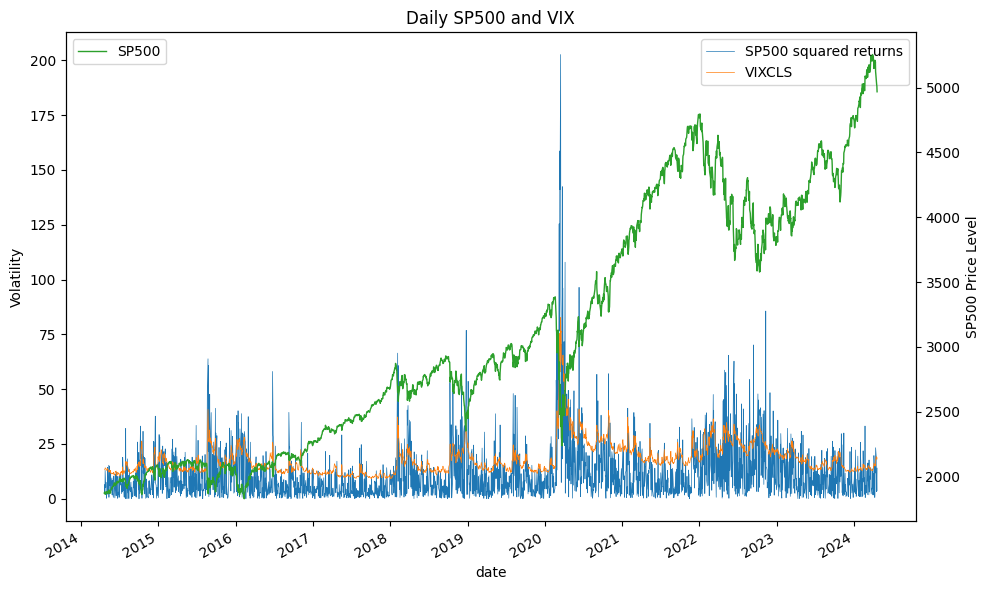

In [17]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE, convert_date=0)
vix = alf('VIXCLS')
sp500_sq = alf('SP500', log=1, diff=1).rename('SP500 squared returns')
sp500 = alf('SP500')
df = pd.concat([100*np.sqrt(252*sp500_sq**2), vix], axis=1, join='inner').dropna()

fig, ax = plt.subplots(figsize=(10, 6))
df.plot(ax=ax, lw=.5)
ax.set_ylabel('Volatility')
bx = ax.twinx()
sp500.plot(ax=bx, lw=1, color="C2")
bx.set_ylabel('SP500 Price Level')
plt.title('Daily SP500 and VIX')
plt.legend()
plt.tight_layout()


### Volatility Smile

In practice, implied volatilities vary with strike prices. This indicates that the market does not price options consistently with the Black-Scholes-Merton assumptions. The volatility smile defines the relationship between the implied volatility of an option and its strike price. Because of put-call parity, the implied volatility of a European call option is the same as that of a European put option when they have the same strike price and time to maturity.


For equity options, the volatility smile tends to be downward sloping. This means that out-of-the-money puts and in-the-money calls tend to have high implied volatilities whereas out-of-the-money calls and in-the-money puts tend to have low implied volatilities.  This is sometimes referred to as a volatility skew. There is a negative correlation between equity prices and volatility, which means that stock price declines are accompanied by increases in volatility, and stock price increases are accompanied by decreases in volatility.

For foreign currency options, the volatility smile is U-shaped. 
Both out-of-the-money and in-the-money options have higher implied volatilities than at-the-money options.  The volatility of an exchange rate is far from constant, and exchange rates frequently exhibit jumps, sometimes in response to the actions of central banks. Both a nonconstant volatility and jumps will have the effect of making extreme outcomes more likely.

Often traders also use a volatility term structure. The implied volatility of an option then depends on its life. When volatility smiles and volatility term structures are combined, they produce a volatility surface. This defines implied volatility as a function of both the strike price and the time to maturity. When quoting options prices, traders interpolate between the known implied volatilities to determine an implied volatility for the option under consideration. This is then substituted into the Black-Scholes-Merton equation to determine the option price. This procedure is a way of overcoming the fact that the market does not price options consistently with the Black-Scholes-Merton assumptions.

### The "Greeks"

The Greek letters (or Greeks, as they are sometimes called) are designed to provide information about the risks of options positions. Some Greek letters are concerned with movements in the price of the underlying asset; some are concerned with volatility changes; and others involve interest rates and dividend yields. Typically, a trader is subject to limits on how large the Greek let­ ters can be. If one of the Greek letters exceeds the applicable limit near the end of the trading day, a trader must either execute a trade that corrects the situation or seek special permission from the risk management function to maintain the existing position.


- Delta measures the sensitivity to changes in the price of the underlying asset: 

$\Delta_c = e^{-qt} \Phi(d_1)$

$\Delta_p = e^{-qt} [\Phi(d_1) - 1]$


- Gamma measures the sensitivity of a portfolio's delta to changes in the price of the underlying asset: 
  
$\Gamma = \dfrac{e^{-qt}}{S \sigma\sqrt{t}}\phi(d_1)$


- Theta measures the sensitity to time to expiration

$\Theta_c = -\dfrac{S\sigma e^{-qt}}{2\sqrt{t}}\phi(d_1) - rKe^{-rt}\Phi(d_2) + qSe^{-qt}\Phi(d_1)$

$\Theta_p = -\dfrac{S\sigma e^{-qt}}{2\sqrt{t}}\phi(d_1) + rKe^{-rt}\Phi(-d_2) - qSe^{-qt}\Phi(-d_1)$



- Vega measures the sensitivity to the implied volatility
  
$V = S e^{-qt} \sqrt{t} \phi(d_1)$




- Rho measures the sensitivity to changes in the level of interest rate 
  
$\rho_c = K t e^{-rt} \Phi(d_2)$

$\rho_p = K t e^{-rt} \Phi(-d_2)$

Any of the Greek letters for a portfolio of derivatives dependent on
the same asset can be calculated as the weighted sum of the Greek letters
for each portfolio component.


The Black-Scholes-Merton analysis can be used to show that
$$\Theta + (r-q) S \Delta + \dfrac{1}{2} \sigma^2 S^2 \Gamma = (r-q) C$$


In [18]:
# Helper to plot a greek over range of stock price S"""
def plot_greek(K, sigma, r, T, greek, S=np.linspace(50, 200, 100),
               ax=None, label='', q=0., c="C0"):
    """helper to plot a greek over range of stock price S"""
    y = [greek(S=s, K=K, sigma=sigma, r=r, T=T, q=q) for s in S]
    ax = ax or plt.gca()
    ax.plot(S, y, color=c)
    #ax.set_xlabel('Stock Price')
    ax.legend([label])

Define and plot options sensitivities

0.5357925584332519
39.73355715246575
0.0158934228609863
-6.727614629584682
44.02299963816157


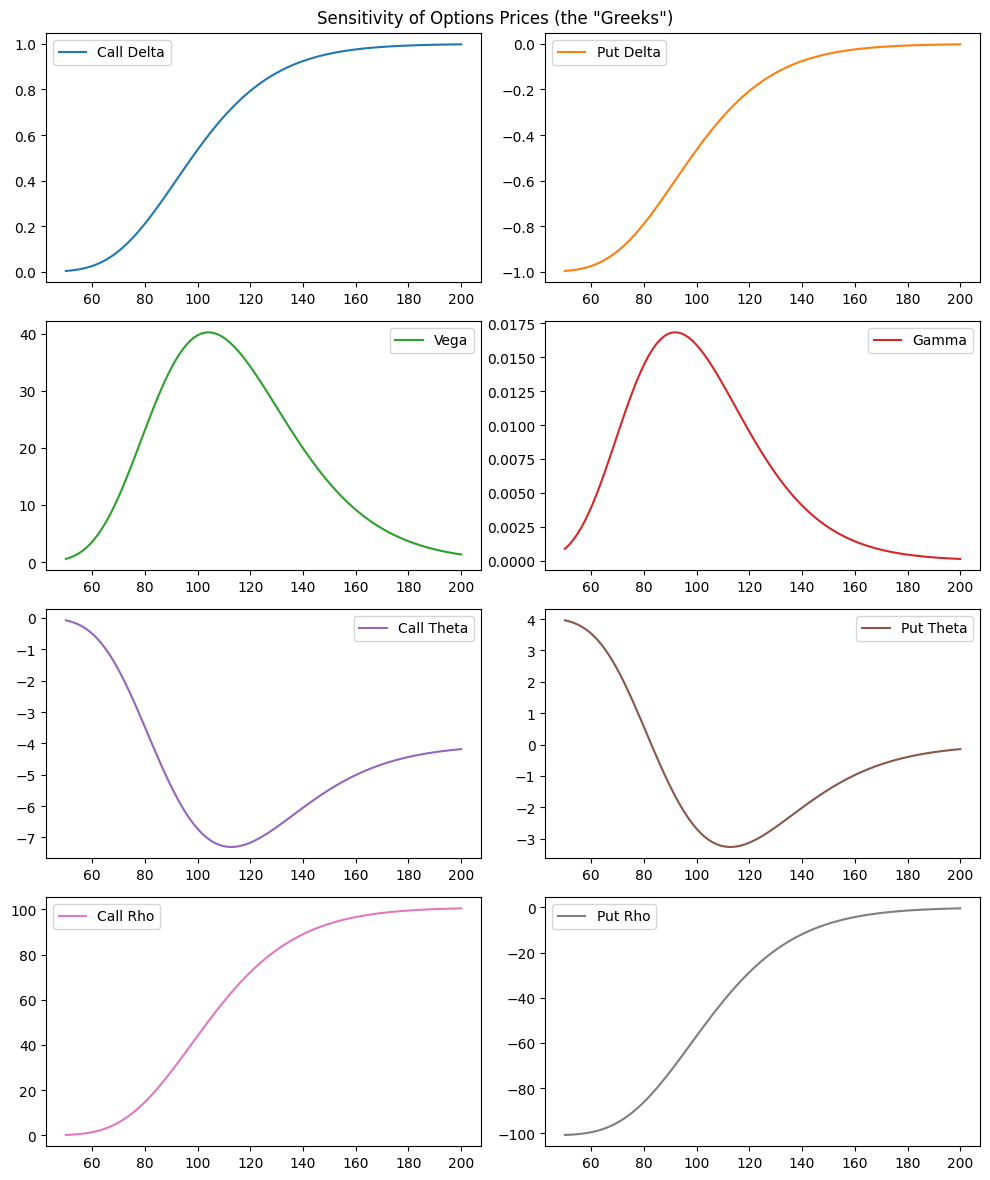

In [19]:
# Plot options sensitivities
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,12))
ax = ax.flatten()

# call option parameters
opt = dict(K=105, r=0.04, sigma=0.25, T=1)

def delta_call(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton call option delta"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    return np.exp(-q*T) * stats.norm.cdf(d1)
def delta_put(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton put option delta"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    return -np.exp(-q*T) * stats.norm.cdf(-d1)
print(delta_call(S=100, **opt))  # 0.5358

plot_greek(greek=delta_call, label='Call Delta', ax=ax[0], c="C0", **opt)
plot_greek(greek=delta_put, label='Put Delta', ax=ax[1], c="C1", **opt)

def vega(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton call or put option delta"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    return S * np.exp(-q*T) * np.sqrt(T) * stats.norm.pdf(d1)
print(vega(S=100, **opt))  # 39.73

plot_greek(greek=vega, label='Vega', ax=ax[2], c="C2", **opt)

def gamma(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton call or put option gamma"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    return np.exp(-q*T) * stats.norm.pdf(d1) / (S * sigma * np.sqrt(T))
print(gamma(S=100, **opt))  # 0.0159

plot_greek(greek=gamma, label='Gamma', ax=ax[3], c="C3", **opt)

def theta_call(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton call option theta"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    d2 = d1 - sigma * np.sqrt(T)
    return ((-S * np.exp(-q*T) * stats.norm.pdf(d1) * sigma / (2 * np.sqrt(T)))
            - (r * K * np.exp(-r*T) * stats.norm.cdf(d2)) +
            + (q * S * np.exp(-q*T) * stats.norm.cdf(d1)))
def theta_put(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton put option theta"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    d2 = d1 - sigma * np.sqrt(T)
    return ((-S * np.exp(-q*T) * stats.norm.pdf(d1) * sigma / (2 * np.sqrt(T)))
            + (r * K * np.exp(-r*T) * stats.norm.cdf(-d2)) +
            - (q * S * np.exp(-q*T) * stats.norm.cdf(-d1)))
print(theta_call(S=100, **opt))  # 6.73

plot_greek(greek=theta_call, label='Call Theta', ax=ax[4], c="C4", **opt)

plot_greek(greek=theta_put, label='Put Theta', ax=ax[5], c="C5", **opt)

def rho_call(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton call option rho"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    d2 = d1 - sigma * np.sqrt(T)
    return K * T * np.exp(-r * T) * stats.norm.cdf(d2)
def rho_put(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton put option rho"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    d2 = d1 - sigma * np.sqrt(T)
    return -K * T * np.exp(-r * T) * stats.norm.cdf(-d2)
print(rho_call(S=100, **opt))  # 44

plot_greek(greek=rho_call, label='Call Rho', ax=ax[6], c="C6", **opt)

plot_greek(greek=rho_put, label='Put Rho', ax=ax[7], c="C7", **opt)

plt.suptitle('Sensitivity of Options Prices (the "Greeks")')
plt.tight_layout()

In [20]:
# Check that: theta + r S delta + 1/2 sigma^2 S^2 gamma = r call
S = 100
print(theta_call(S=S, **opt) + opt['r'] * S * delta_call(100, **opt) +
      0.5 * opt['sigma']**2 * S**2 * gamma(S=S, **opt),
      opt['r'] * call(S=S, **opt))

0.3822502482065442 0.38225024820654485


## Monte Carlo Simulation

Simulation provides a simple method to approximate the analytically intractable expectation. Suppose X is a random variable that can be simulated (e.g., a normal) and g is a function that can be evaluated at realizations of X.

Simulated draws are iid by construction, and b draws are used to approximate the expected value as:
$\hat{E}[g(X)] = \dfrac{1}{b} \sum_{i=1}^b g(X_i)$

The approximated expectation is an average of b iid random variables, and so the Law of Large Numbers (LLN) applies: 
$b \lim_{b\rightarrow \inf} \hat{E}[g(X)] = E[g(X)]$

Furthermore, the Central Limit Theorem (CLT) also applies to the average. The variance of the simulated expectation is estimated by:
$V[\hat{E}[g(X)]] = \sigma^2_b / b$

This variance is estimated using: 
$\sigma^2_g = \dfrac{1}{b} \sum_{i=1}^b (g(X_i) - E[g(X_i)])^2$
which is the standard variance estimator for iid data.

The standard error of the simulated expectation
$\sigma_g/\sqrt{b}$ measures the accuracy of the approximation, which allows b to be chosen to achieve any desired level of accuracy.

### Antithetic Variates

Antithetic variates add a second set of random variables that are constructed to have a negative correlation with the iid vari-ables used in the simulation. They are generated in pairs using a single uniform value.  Only $b/2$ uniforms are required to produce $b$ simulated values because each draw $U-i$ also generates the $1-U_i$ which both map through the inverse CDF to generate random variables that are negatively correlated.  

Antithetic pairs produced using this algorithm are only guaranteed to reduce the simulation error if the function g(X) is monotonic to ensure negative correlation. The improvement in accuracy when using antithetic variables occurs due to the negative correlation between the paired random variables which decreases standard error.


### Control Variates

A control variate is another derived random variable $h(X_i)$ that has mean 0 but is correlated with the error of the primary random variable $g(X_i)$. A good control variate should have two properties.
1. First, it should be inexpensive to construct from $x_i$, than the computation cost of simply increasing the number of simulations.
2. Second, a control variate should have a high correlation with $g(X)$. The optimal combination parameter $\beta$ that minimizes the approximation error is estimated using the regression: 
3. $g(x_i) = \alpha + \beta h(x_i)$



### Simulating Option Prices

Assume that the log of the stock price is normally distributed. The time T log stock price $s_T$ is equal to the sum of the initial stock price $s_0$, a mean, and a normally distributed error:

$s_T = s_0 + T(r_f - \sigma^2/2) + \sqrt{T}x_i$

where $x_i$ is a simulated value from a $N(0, \sigma^2)$, $r_f$ is the risk-free rate, and $\sigma^2$ is the variance of the stock return.

The final stock price is ST = exp(sT), and the present value of the option’s payoff is 

$C = \exp(-r_f T) \max(S_T - K, 0)$

The expected price of a call option is estimated by the average of the simulated values:

$E[C] = \overline{C} = \dfrac{1}{b}\sum_{i=1}^b C_i$

where $C_i$ are simulated values of the payoff of the call option.



In [21]:
# helpers for random number generator and monte carlo simulation
class RNG:
    """Helper to generate random normal variables, with optional antithetic variates"""
    def __init__(self, seed=None, antithetic=False, ppf=stats.norm.ppf):
        self.ppf = ppf
        self.antithetic = antithetic
        self._prev = None   # to track if antithetic pair available to return next
        self.seed = seed
        self.rng = np.random.default_rng(seed)

    def __call__(self, shape=1, **kwargs):
        _shape = (shape, ) if isinstance(shape, int) else shape
        n = np.prod(_shape)
        if self.antithetic:  # generate half as many rv's, by returning 1-rv
            new = int((n + 1) / 2) if self._prev is None else int(n / 2)
            new = self.rng.random((new,))
            rem = 1 - new[:n - len(new) - int(self._prev is not None)]
            last = new[-1] if len(rem) < len(new) else None   # if last pair unused
            out = [] if self._prev is None else [1 - self._prev]
            #out.extend(new)
            #out.extend(rem)
            for x, y in zip(new[:len(rem)], rem):
                out.extend([x, y])
            if last is not None:
                out.extend([last])
            out = np.array(out)
            self._prev = last
        else:
            out = self.rng.random(_shape)
        if shape == 1:
            return self.ppf(out[0], **kwargs)
        else:
            return self.ppf(out.reshape(_shape), **kwargs)

def monte_carlo(rng, S, K, sigma, r, T, control=None):
    """Helper to price European call option by Monte Carlo Simulation
    Args:
      control : True price of European put option, as control variate
    """
    if rng.antithetic:
        label = 'Both' if control else 'Antithetic'
    else:
        label = 'Control' if control else 'Standard'
    result = {}
    for b in [50*4**i for i in range(9)]:
        tic = time.time()
        x = rng(b, scale=sigma)
        s = S * np.exp(T * (r - sigma**2/2) + np.sqrt(T) * x)
        c = np.exp(-r * T) * np.maximum(s - K, 0)
        if control is not None:   # to apply control variate method
            error = np.exp(-r * T) * np.maximum(K - s, 0) - control  # error of put price
            ols = stats.linregress(x=error, y=c)  # compute best hedge to minimize error
            c = c - ols.slope * error
        result[b] = dict(Price=np.mean(c).round(2),
                         StdErr=(np.std(c) / np.sqrt(b)).round(2),
                         elapsed = np.round(time.time() - tic, 4))
    return DataFrame.from_dict(result, orient='index').rename_axis(columns=label)

RNG(antithetic=True)((2, 3))   # generate normal r.v.'s with antithetic variates

array([[-1.49453301,  1.49453301,  0.80816507],
       [-0.80816507, -0.28928827,  0.28928827]])

Standard simulation


In [22]:
S = 2500
K = 2500
sigma = 0.164
r = 0.02
T = 2

seed = 42
rng = RNG(seed=seed)
monte_carlo(rng, S=S, K=K, sigma=sigma, r=r, T=T)

Standard,Price,StdErr,elapsed
50,297.91,54.77,0.0004
200,247.65,25.97,0.0002
800,283.95,15.23,0.0003
3200,279.62,7.59,0.0004
12800,278.25,3.73,0.0009
51200,279.45,1.85,0.0021
204800,278.93,0.93,0.0081
819200,278.31,0.46,0.0361
3276800,278.59,0.23,0.2964


Antithetic Variates


In [23]:
rng = RNG(seed=seed, antithetic=True)
monte_carlo(rng, S=S, K=K, sigma=sigma, r=r, T=T)

Antithetic,Price,StdErr,elapsed
50,280.86,54.41,0.0004
200,242.12,25.04,0.0003
800,276.97,14.15,0.0007
3200,284.38,7.63,0.0006
12800,277.30,3.72,0.0019
51200,279.28,1.87,0.0070
204800,278.15,0.93,0.0298
819200,278.46,0.46,0.1209
3276800,278.48,0.23,0.4569


Control Variates


In [24]:
control = put(S, K, sigma, r, T)   # Black-Scholes-Merton put price
rng = RNG(seed=seed)
monte_carlo(rng, S=S, K=K, sigma=sigma, r=r, T=T, control=control)

Control,Price,StdErr,elapsed
50,263.59,47.04,0.0005
200,251.85,22.76,0.0003
800,287.49,13.52,0.0005
3200,279.92,6.76,0.0004
12800,278.43,3.32,0.0007
51200,279.01,1.64,0.0027
204800,279.02,0.83,0.0120
819200,278.22,0.41,0.0453
3276800,278.64,0.21,0.3122


Both Antithetic and Control Variates


In [25]:
control = put(S, K, sigma, r, T)    # Black-Scholes-Merton put price
rng = RNG(seed=seed, antithetic=True)
monte_carlo(rng, S=S, K=K, sigma=sigma, r=r, T=T, control=control)

Both,Price,StdErr,elapsed
50,286.14,45.71,0.0005
200,227.29,22.03,0.0006
800,277.91,12.32,0.0004
3200,286.51,6.79,0.0006
12800,276.56,3.31,0.0020
51200,279.47,1.66,0.0063
204800,277.88,0.83,0.0273
819200,278.41,0.41,0.1039
3276800,278.41,0.21,0.5222
